# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [21]:
!pip install --upgrade pip

In [22]:
!pip install torchsummary

In [23]:
# Load required python libraries
from glob import glob
from tqdm import tqdm
from PIL import Image
from PIL import ImageFile
import cv2                
import os
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchsummary import summary
from torchvision import datasets
import matplotlib.pyplot as plt   

In [24]:
# Upgrade pytortch version
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [25]:
print(torch.__version__)

0.4.0


In [26]:
print(torchvision.__version__)

0.2.1


In [27]:
# Check CUDA version
!nvidia-smi

Sun May 30 20:05:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    74W / 149W |   4832MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [29]:
# take a data sample
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


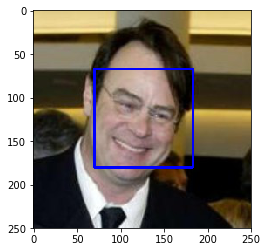

In [135]:
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [136]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [137]:
#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# Create a dictionary to save results
results = {'dogs': 0, 'humans': 0}

# Count the number of faces detected using face_detector for the human_files_short sample
for human_image in human_files_short:
    if face_detector(human_image):
        results['humans'] = results['humans'] + 1

# Count the number of faces detected using face_detector for the dog_files_short sample
for dog_image in dog_files_short:
    if face_detector(dog_image):
        results['dogs'] = results['dogs'] + 1
    
# Print the human faces detected in the humans sample     
print ("faces detected in humans sample:", results['humans'])

# Print the human faces detected in the dogs sample     
print ("faces detected in dogs sample:", results['dogs'])

faces detected in humans sample: 98
faces detected in dogs sample: 17


**Answer**

|       Sample      | faces detected | Percentage obtained |
|:-----------------:|:--------------:|:-------------------:|
| human_files_short |       98       |         98%         |
| dog_files_short   |       17       |         17%         |

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [8]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [34]:
# Set PIL to be tolerant of image files that are truncated.
ImageFile.LOAD_TRUNCATED_IMAGES = True

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    
# Print the model summary
summary(VGG16, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:12<00:00, 45934601.38it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [35]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Initialize the transformation steps to apply in the image
    transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
                )])
    
    # Prepate the image for the pretrained model
    image_proccesed = torch.unsqueeze(transform(Image.open(img_path)),0).cuda()   
    
    # Execute model evaluation
    VGG16.eval()
    
    
    # Execute model evaluation
    VGG16.eval()
    
    # Perform model evaluation and apply max function
    _, result = torch.max(VGG16(image_proccesed),1)
    
    # Perform model evaluation
    _, prediction = torch.max(VGG16(image_proccesed),1)
    return prediction

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [36]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    predicted_class = VGG16_predict(img_path)
    
    return (predicted_class >= 151 and predicted_class <= 268) # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [37]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# Create a dictionary to save results
results_vgg16 = {'dogs': 0, 'humans': 0}

# Count the number of faces detected using face_detector for the human_files_short sample
for human_image in human_files_short:
    if dog_detector(human_image):
        results_vgg16['humans'] = int(results_vgg16['humans']) + 1

# Count the number of faces detected using face_detector for the dog_files_short sample
for dog_image in dog_files_short:
    if dog_detector(dog_image):
        results_vgg16['dogs'] = int(results_vgg16['dogs']) + 1
    
# Print the human faces detected in the humans sample     
print ("Dogs detected in humans sample:", results_vgg16['humans'])

# Print the human faces detected in the dogs sample     
print ("Dogs detected in dogs sample:", results_vgg16['dogs'])

Dogs detected in humans sample: 0
Dogs detected in dogs sample: 100


**Answer**

|       Sample      | Dogs detected | Percentage obtained |
|:-----------------:|:-------------:|:-------------------:|
| human_files_short |       0       |          0%         |
| dog_files_short   |      100      |         100%        |

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [10]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

## Test the Wide Resnet 

ImageFile.LOAD_TRUNCATED_IMAGES = True

# define Wide resnet 50 model
RESNET50 = models.resnet50(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# # move model to GPU if CUDA is available
if use_cuda:
    RESNET50 = RESNET50.cuda()
    
# Print the model summary
summary(RESNET50, (3, 224, 224))    

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:07<00:00, 13296906.33it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [14]:
def RESNET50_predict(img_path):
    '''
    Use pre-trained RESNET-50 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to RESNET-50 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Initialize the transformation steps to apply in the image
    transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]                   
                )])
    
    # Prepate the image for the pretrained model
    image_proccesed = torch.unsqueeze(transform(Image.open(img_path).convert("RGB")),0).cuda()   
    
    # Execute model evaluation
    RESNET50.eval()
    
    _, result = torch.max(RESNET50(image_proccesed),1)
    
    # Perform model evaluation and apply softmax function
    prediction = int(result.cpu().data.numpy().squeeze()) 
    
    return prediction

In [15]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector_resnet(img_path):
    predicted_class = RESNET50_predict(img_path)
    
    return (predicted_class >= 151 and predicted_class <= 268) # true/false

In [16]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# Create a dictionary to save results
results_RESNET50 = {'dogs': 0, 'humans': 0}

# Count the number of faces detected using face_detector for the human_files_short sample
for human_image in human_files_short:
    if dog_detector_resnet(human_image):
        results_RESNET50['humans'] = int(results_RESNET50['humans']) + 1

# Count the number of faces detected using face_detector for the dog_files_short sample
for dog_image in dog_files_short:
    if dog_detector_resnet(dog_image):
        results_RESNET50['dogs'] = int(results_RESNET50['dogs']) + 1
    
# Print the human faces detected in the humans sample     
print ("Dogs detected in humans sample:", results_RESNET50['humans'])

# Print the human faces detected in the dogs sample     
print ("Dogs detected in dogs sample:", results_RESNET50['dogs'])

Dogs detected in humans sample: 0
Dogs detected in dogs sample: 100


**Answer**

|       Sample      | Dogs detected | Percentage obtained |
|:-----------------:|:-------------:|:-------------------:|
| human_files_short |       0       |          0%         |
| dog_files_short   |     100       |        100%         |

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [144]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# define constants
IMAGE_SIZE = 224
IMAGE_RESIZE = 255
LOADER_BATCH_SIZE = 8
NUM_WORKERS = 0

# define image transformer for model use
transform_data = transforms.Compose([transforms.Resize(IMAGE_RESIZE),
                                      transforms.RandomRotation(28),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop((IMAGE_SIZE, IMAGE_SIZE)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

# Load images for training
data_train = datasets.ImageFolder('/data/dog_images/train', transform=transform_data)

# Load images for test
data_test = datasets.ImageFolder('/data/dog_images/test', transform=transform_data)

# Load images for validation
data_validation = datasets.ImageFolder('/data/dog_images/valid', transform=transform_data)

# create the data loaders
data_train_loader = torch.utils.data.DataLoader(data_train, 
                                                batch_size=LOADER_BATCH_SIZE, 
                                                shuffle=True, 
                                                pin_memory=True, 
                                                num_workers=NUM_WORKERS)

data_valid_loader = torch.utils.data.DataLoader(data_validation, 
                                                batch_size=LOADER_BATCH_SIZE, 
                                                shuffle=True,
                                                pin_memory=True, 
                                                num_workers=NUM_WORKERS)

data_test_loader = torch.utils.data.DataLoader(data_test, 
                                               batch_size=LOADER_BATCH_SIZE, 
                                               shuffle=True, 
                                               pin_memory=True, 
                                               num_workers=NUM_WORKERS)

# dictionary containing the loaders.
loader_scratch = {
                    'train': data_train_loader, 
                    'valid': data_valid_loader,
                    'test': data_test_loader
                 }

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

Transforms function was used to apply transformation and data augmentation to all the datasets:

 - transforms.Resize(IMAGE_RESIZE): Resized the images to 256 px as is required by the Image classification Models.
 - transforms.RandomRotation(28): Apply a random rotation between 0-28 grades
 - transforms.RandomHorizontalFlip(): Generate random horizontal flip for data augmentation
 - transforms.CenterCrop((IMAGE_SIZE, IMAGE_SIZE)): Center cropped to 224 px
 - transforms.Normalize: Applu normalizarion with 0.5 mean and 0.5 std

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [10]:
# Import Pytorch libraries
import torch.nn as nn
import torch.nn.functional as F

# check if CUDA is available
use_cuda = torch.cuda.is_available()

### Model 1 Small Size

 - 3 convolutional layers
 - Max pooling
 - Batch normalization
 - Dropout
 - 2 fully connected layers

In [11]:
PADDING = 1
KERNEL_SIZE = 3
FEATURES = 133

# define the CNN architecture
class Net_small(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self, n_features):
        super(Net_small, self).__init__()
        ## Define layers of a CNN
        
        # Add a convolutional layer Input: image size (224 x 224 x 3)
        self.conv1=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=KERNEL_SIZE, stride=2, padding=PADDING)
        
        # Add a convolutional layer Input: (56 x 56 x 32) Output: (28 x 28 x 64)
        self.conv2=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=KERNEL_SIZE, stride=2, padding=PADDING)

        # Add a bath normalization layer for 64 input features
        self.bn1 = nn.BatchNorm2d(num_features=64)
        
        # Add a convolutional layer Input: image size (28 x 28 x 64) Output: (7 x 7 x 32)
        self.conv3=nn.Conv2d(in_channels=64, out_channels=32, kernel_size=KERNEL_SIZE, padding=PADDING)        
        
        # Pooling layer
        self.pool=nn.MaxPool2d(2,2)
        
        # Fully connected layers input 1568 output 512
        self.fc1=nn.Linear(1568, 512)
        
        # Fully connected layers input 512 out number of features
        self.fc2=nn.Linear(512, n_features)

        # Dropout layer
        self.drop=nn.Dropout(p=0.4)               

        # Batch normalization output n_features
        self.batch_norm = nn.BatchNorm1d(512)            
        
    
    def forward(self, x):
        ## Define forward behavior
        
        # Add dropout layer
        x=self.pool(F.relu(self.conv1(x)))
        
        # Add a hidden layer with RELU activation
        x=self.pool(F.relu(self.conv2(x)))
        
        # Add a hidden layer with RELU activation
        x=self.pool(F.relu(self.conv3(x)))
        
        # Add dropout layer
        x=x.view(-1,1568)
      
        # Add dropout layer
        x=self.drop(x)
        
        # Add fully connected layer with relu activation function
        x=self.batch_norm(F.relu(self.fc1(x)))
        
        # Add dropout layer
        x=self.drop(x)        
        
        # Add fully connected layer with relu activation function
        x=F.relu(self.fc2(x))
    
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch_small = Net_small(FEATURES)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch_small.cuda()

In [33]:
# Print model summary
summary(model_scratch_small, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
         MaxPool2d-2           [-1, 32, 56, 56]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]          18,464
         MaxPool2d-6             [-1, 32, 7, 7]               0
           Dropout-7                 [-1, 1568]               0
            Linear-8                  [-1, 512]         803,328
       BatchNorm1d-9                  [-1, 512]           1,024
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 133]          68,229
Total params: 910,437
Trainable params: 910,437
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/

### Model 2 Medium Size
 - 5 convolutional layers
 - Max pooling
 - Batch normalization
 - Dropout
 - 3 fully connected layers

In [12]:
PADDING = 1
KERNEL_SIZE = 3
FEATURES = 133

# define the CNN architecture
class Net_medium(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self, n_features):
        super(Net_medium, self).__init__()
        ## Define layers of a CNN
        
        # Add a convolutional layer Input: image size (224 x 224 x 3) Output: (112 x 112 x 128)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=KERNEL_SIZE, stride=2, padding=PADDING)
        
        # Add a bath normalization layer for 128 input features       
        self.bn1 = nn.BatchNorm2d(num_features=128)
        
        # Add a convolutional layer Input: input size (112 x 112 x 128) Output: (56 x 56 x 64)        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=KERNEL_SIZE, stride=1, padding=PADDING)
        
        # Add a bath normalization layer for 64 input features        
        self.bn2 = nn.BatchNorm2d(num_features=64)
        
        # Add a convolutional layer Input: input size (56 x 56 x 64) Output: (28 x 28 x 32)     
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=KERNEL_SIZE, stride=1, padding=PADDING)
               
        # Add a convolutional layer Input: input size (28 x 28 x 32) Output: (14 x 14 x 64)        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=KERNEL_SIZE, stride=1, padding=PADDING)
                
        # Add a convolutional layer Input: input size (14 x 14 x 64) Output: (7 x 7 x 32)        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=KERNEL_SIZE, stride=1, padding=PADDING)
        
        # Add a maxpool layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # add fully connected layer input (1568) output (784)        
        self.fc1 = nn.Linear(in_features=1568, out_features=784)
        
        #Fully connected layers input (784) output (382)
        self.fc2 = nn.Linear(in_features=784,out_features=382)
        
        # add dropout layer
        self.dropout = nn.Dropout(p=0.4)
        
        # add fully connected layer
        self.fc3 = nn.Linear(in_features=382, out_features=n_features)          
        
        # add fully a batch normalization layer
        self.batch_norm = nn.BatchNorm1d(num_features=n_features) 
    
    
    def forward(self, x):
        ## Define forward behavior
        
        # Add convolutional layer with relu activation function and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Add convolutional layer with relu activation function
        x = F.relu(self.bn2(self.conv2(x)))
                
        # Add convolutional layer with relu activation function and pooling
        x = self.pool(F.relu(self.conv3(x)))
                
        # Add convolutional layer with relu activation function and pooling
        x = self.pool(F.relu(self.conv4(x)))
                
        # Add convolutional layer with relu activation function and pooling
        x = self.pool(F.relu(self.conv5(x)))    
        
        # Add dropout layer
        x = x.view(-1,1568)
        
        # drooput layer
        x = self.dropout(x)
        
        # Add dropout layer        
        x = self.dropout(F.relu(self.fc1(x)))
        
        # Add dropout layer        
        x = self.dropout(F.relu(self.fc2(x)))
        
        # Add a fully connected layer
        x = self.batch_norm(self.fc3(x))
        
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch_medium = Net_medium(FEATURES)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch_medium.cuda()

In [12]:
# Print model summary
summary(model_scratch_medium, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 112, 112]           3,584
       BatchNorm2d-2        [-1, 128, 112, 112]             256
         MaxPool2d-3          [-1, 128, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          73,792
       BatchNorm2d-5           [-1, 64, 56, 56]             128
            Conv2d-6           [-1, 32, 56, 56]          18,464
         MaxPool2d-7           [-1, 32, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          18,496
         MaxPool2d-9           [-1, 64, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]          18,464
        MaxPool2d-11             [-1, 32, 7, 7]               0
          Dropout-12                 [-1, 1568]               0
           Linear-13                  [-1, 784]       1,230,096
          Dropout-14                  [

### Model 3 Big Size
 - 10 convolutional layers
 - Max pooling
 - Batch normalization
 - Dropout
 - 3 fully connected layers

In [141]:
PADDING = 1
KERNEL_SIZE = 3
FEATURES = 133

# define the CNN architecture
class Net_big(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self, n_features):
        super(Net_big, self).__init__()
        ## Define layers of a CNN
        
        # Add a convolutional layer Input: image size (224 x 224 x 3) Output: (224 x 224 x 64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=KERNEL_SIZE, stride=1, padding=PADDING)
        
        # Add a bath normalization layer for 128 input features       
        self.bn1 = nn.BatchNorm2d(num_features=64)
        
        # Add a convolutional layer Input: input size (112 x 112 x 128) Output: (56 x 56 x 64)        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=KERNEL_SIZE, stride=1, padding=PADDING)
        
        # Add a bath normalization layer for 64 input features        
        self.bn2 = nn.BatchNorm2d(num_features=128)
        
        # Add a convolutional layer Input: input size (56 x 56 x 64) Output: (28 x 28 x 32)     
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=KERNEL_SIZE, stride=1, padding=PADDING)

        # Add a bath normalization layer for 256 input features        
        self.bn3 = nn.BatchNorm2d(num_features=256)        
        
        # Add a convolutional layer Input: input size (28 x 28 x 32) Output: (14 x 14 x 64)        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=KERNEL_SIZE, stride=1, padding=PADDING)
                
        # Add a convolutional layer Input: input size (7 x 7 x 64) Output: (7 x 7 x 32)        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=KERNEL_SIZE, stride=1, padding=PADDING)
        
        # Add a convolutional layer Input: input size (14 x 14 x 64) Output: (7 x 7 x 32)        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=KERNEL_SIZE, stride=1, padding=PADDING)
        
        # Add a convolutional layer Input: input size (14 x 14 x 64) Output: (7 x 7 x 32)        
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=KERNEL_SIZE, stride=1, padding=PADDING)        
        
        # Add a convolutional layer Input: input size (14 x 14 x 64) Output: (7 x 7 x 32)        
        self.conv8 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=KERNEL_SIZE, stride=1, padding=PADDING)        
        
        # Add a maxpool layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                
        
        # add fully connected layer with relu activation function        
        self.fc1 = nn.Linear(in_features=1568, out_features=784)
        
        #Fully connected layers input (3136) output (512)
        self.fc2 = nn.Linear(in_features=784,out_features=392)
        
        # add dropout layer
        self.dropout = nn.Dropout(p=0.4)
        
        # add fully connected layer with relu activation function
        self.fc3 = nn.Linear(in_features=392, out_features=n_features)   
        
        # add fully a batch normalization layer
        self.batch_norm = nn.BatchNorm1d(num_features=n_features) 
    
    
    def forward(self, x):
        ## Define forward behavior
        
        # add fully connected layer with relu activation function        
        x = F.relu(self.bn1(self.conv1(x)))
        
        # add fully connected layer with relu activation function        
        x = F.relu(self.bn2(self.conv2(x)))
                
        # add fully connected layer with relu activation function        
        #x = F.relu(self.bn2(self.conv2(x)))
                
        # add fully connected layer with relu activation function
        x = self.pool(F.relu(self.conv3(x)))
                
        # add fully connected layer with relu activation function        
        x = F.relu(self.bn3(self.conv4(x)))
                
        # add fully connected layer with relu activation function        
        x = self.pool(F.relu(self.conv5(x)))
        
        # add fully connected layer with relu activation function        
        x = self.pool(F.relu(self.conv6(x)))    
                
        # add fully connected layer with relu activation function        
        x = self.pool(F.relu(self.conv7(x))) 
            
        # add fully connected layer with relu activation function        
        x = self.pool(F.relu(self.conv8(x)))
        
        # Add dropout layer
        x=x.view(-1,1568)
        
        # Add fully connected layer        
        x = F.relu(self.fc1(x))
        
        # Add a dropuout layer
        x = self.dropout (x)
        
        # Add fully connected layer wirh relu activation function        
        x = self.dropout(F.relu(self.fc2(x)))
        
        # Add a dully connected layer
        x = x = self.batch_norm(self.fc3(x))
        
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch_big = Net_big(FEATURES)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch_big.cuda()

In [25]:
# Print model summary
summary(model_scratch_big, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
            Conv2d-3        [-1, 128, 224, 224]          73,856
       BatchNorm2d-4        [-1, 128, 224, 224]             256
            Conv2d-5        [-1, 128, 224, 224]         147,584
         MaxPool2d-6        [-1, 128, 112, 112]               0
            Conv2d-7        [-1, 256, 112, 112]         295,168
       BatchNorm2d-8        [-1, 256, 112, 112]             512
            Conv2d-9        [-1, 256, 112, 112]         590,080
        MaxPool2d-10          [-1, 256, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]         295,040
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          73,792
        MaxPool2d-14           [-1, 64,

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

First, I read some references about CNN for image classification with some examples and recommendations. The main reference used was:  https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/. Some recommendation is to define different models with different complexity (Layer numbers and pooling operations) and check for normalization, regularization, and dropout to improve results and avoid overfitting. All models get an input of 224 x 224 x 3 (Image size and RGB channels) and output for 133 classes. I defined three different models:

**Small size Model (Base Model)**

This is the base model, which has basic convolutional layers and a fully connected layer to map the tensors to the output size.

 - 3 convolutional layers
 - Max pooling
 - Batch normalization
 - Dropout
 - 2 fully connected layers


| Layer (type)                                                     | Output Shape       | Param #   |
|------------------------------------------------------------------|:-------------------|:----------|
| Conv2d-1                                                         | [-1, 32, 112, 112] |       896 |
| MaxPool2d-2                                                      | [-1, 32, 56, 56]   |         0 |
| Conv2d-3                                                         | [-1, 64, 28, 28]   |    18,496 |
| MaxPool2d-4                                                      | [-1, 64, 14, 14]   |         0 |
| Conv2d-5                                                         | [-1, 32, 14, 14]   |    18,464 |
| MaxPool2d-6                                                      | [-1, 32, 7, 7]     |         0 |
| Dropout-7                                                        | [-1, 1568]         |         0 |
| Linear-8                                                         | [-1, 133]          |   208,677 |
| BatchNorm1d-9                                                    | [-1, 133]          |       266 |

====================================================================================================
 - Total params:     246,799
 - Trainable params: 246,799
 - Non-trainable params:   0



This model uses dropout and batch normalization.


**Medium size Model**

This model a couple more convolutional layers trying to improve the classification task and add batch normalization between convolutional layers.

 - 5 convolutional layers
 - Max pooling
 - Batch normalization
 - Dropout
 - 3 fully connected layers

| Layer (type)                                                     | Output Shape        | Param #   |
|------------------------------------------------------------------|:--------------------|:----------|
| Conv2d-1                                                         | [-1, 128, 112, 112] |     3,584 |
| BatchNorm2d-2                                                    | [-1, 128, 112, 112] |       256 |
| MaxPool2d-3                                                      | [-1, 128, 56, 56]   |         0 |
| Conv2d-4                                                         | [-1, 64, 56, 56]    |    73,792 |
| BatchNorm2d-5                                                    | [-1, 64, 56, 56]    |       128 |
| Conv2d-6                                                         | [-1, 32, 56, 56]    |    18,464 |
| MaxPool2d-7                                                      | [-1, 32, 28, 28]    |         0 |
| Conv2d-8                                                         | [-1, 64, 28, 28]    |    18,496 |
| MaxPool2d-9                                                      | [-1, 64, 14, 14]    | 0         |
| Conv2d-10                                                        | [-1, 32, 14, 14]    | 18,464    |
| MaxPool2d-11                                                     | [-1, 32, 7, 7]      | 0         |
| Dropout-12                                                       | [-1, 1568]          | 0         |
| Linear-13                                                        | [-1, 784]           | 1,230,096 |
| Dropout-14                                                       | [-1, 784]           | 0         |
| Linear-15                                                        | [-1, 382]           | 299,870   |
| Dropout-16                                                       | [-1, 382]           | 0         |
| Linear-17                                                        | [-1, 133]           | 50,939    |
| BatchNorm1d-18                                                   | [-1, 133]           | 266       |

======================================================================================================
 - Total params:     1,714,355 
 - Trainable params: 1,714,355
 - Non-trainable params:     0

For this model was used 30 epochs


**Big Size Model**

This mode adds more convolutional layer trying to capture more image characteristics but increase the number of the parameters over 3 million making the model take more than 10 hours to be trained. The model is basically similar to the base model but adds 7 more convolutional layers.

 - 8 convolutional layers
 - Max pooling
 - Batch normalization
 - Dropout
 - Fully connected layers
 
| Layer (type)                                                     | Output Shape        | Param #   |
|------------------------------------------------------------------|---------------------|-----------|
| Conv2d-1                                                         | [-1, 64, 224, 224]  | 1,792     |
| BatchNorm2d-2                                                    | [-1, 64, 224, 224]  | 128       |
| Conv2d-3                                                         | [-1, 128, 224, 224] | 73,856    |
| BatchNorm2d-4                                                    | [-1, 128, 224, 224] | 256       |
| Conv2d-5                                                         | [-1, 128, 224, 224] | 147,584   |
| MaxPool2d-6                                                      | [-1, 128, 112, 112] | 0         |
| Conv2d-7                                                         | [-1, 256, 112, 112] | 295,168   |
| BatchNorm2d-8                                                    | [-1, 256, 112, 112] | 512       |
| Conv2d-9                                                         | [-1, 256, 112, 112] | 590,080   |
| MaxPool2d-10                                                     | [-1, 256, 56, 56]   | 0         |
| Conv2d-11                                                        | [-1, 128, 56, 56]   | 295,040   |
| MaxPool2d-12                                                     | [-1, 128, 28, 28]   | 0         |
| Conv2d-13                                                        | [-1, 64, 28, 28]    | 73,792    |
| MaxPool2d-14                                                     | [-1, 64, 14, 14]    | 0         |
| Conv2d-15                                                        | [-1, 32, 14, 14]    | 18,464    |
| MaxPool2d-16                                                     | [-1, 32, 7, 7]      | 0         |
| Linear-17                                                        | [-1, 784]           | 1,230,096 |
| Dropout-18                                                       | [-1, 784]           | 0         |
| Linear-19                                                        | [-1, 392]           | 307,720   |
| Dropout-20                                                       | [-1, 392]           | 0         |
| Linear-21                                                        | [-1, 133]           | 52,269    |
| BatchNorm1d-22                                                   | [-1, 133]           | 266       |
 
 =====================================================================================================
 
 - Total params: 3,087,023
 - Trainable params: 3,087,023
 - Non-trainable params: 0

For this model the result running only 20 epochs executed due to the long training time required. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [38]:
from PIL import ImageFile
import torch.optim as optim

### TODO: select loss function

# Set CrossEntropyLoss as the loss function
criterion_scratch = nn.CrossEntropyLoss()

# Define learning rate
LEARNING_RATE = 0.01

#The following code is to overcome a common error "OSError: image file is truncated (150 bytes not processed) error." during training
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
### TODO: select optimizer for small size model

# Choose SDG - Stochastic Gradient Descendent optimization
optimizer_scratch_small = optim.SGD(model_scratch_small.parameters(), lr=LEARNING_RATE)

In [ ]:
### TODO: select optimizer for medium size model

# Choose SDG - Stochastic Gradient Descendent optimization
optimizer_scratch_medium = optim.SGD(model_scratch_medium.parameters(), lr=LEARNING_RATE)

In [142]:
### TODO: select optimizer for big size model

# Choose SDG - Stochastic Gradient Descendent optimization
optimizer_scratch_big = optim.SGD(model_scratch_big.parameters(), lr=LEARNING_RATE)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [39]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        
            #initializing optimizer weights to zero 
            optimizer.zero_grad()    
        
            #calling the model's forward pass
            output=model(data)
            
            #calculating loss
            loss=criterion(output,target)
        
            #backpropagation
            loss.backward()
        
            #optimization step
            optimizer.step()
        
            #updating training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))    

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## update the average validation loss
            output=model(data)
            
            loss=criterion(output,target)
            
            valid_loss = valid_loss + ((1/(batch_idx + 1))*(loss.data - valid_loss))
            
            model.eval()

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
       
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('validation loss decreased from {:.6f} to {:.6f}. Model is being saved.'.format(
                valid_loss_min,
                valid_loss))
            
            valid_loss_min=valid_loss
            torch.save(model.state_dict(),save_path)
        
        # return trained model
    return model

In [36]:
EPOCHS = 50
# train the model small
model_scratch_small = train(EPOCHS, loader_scratch, model_scratch_small, optimizer_scratch_small, 
                      criterion_scratch, use_cuda, 'model_scratch_small.pt')

Epoch: 1 	Training Loss: 4.863119 	Validation Loss: 4.772037
validation loss decreased from inf to 4.772037. Model is being saved.
Epoch: 2 	Training Loss: 4.727519 	Validation Loss: 4.629987
validation loss decreased from 4.772037 to 4.629987. Model is being saved.
Epoch: 3 	Training Loss: 4.586916 	Validation Loss: 4.527840
validation loss decreased from 4.629987 to 4.527840. Model is being saved.
Epoch: 4 	Training Loss: 4.489980 	Validation Loss: 4.410886
validation loss decreased from 4.527840 to 4.410886. Model is being saved.
Epoch: 5 	Training Loss: 4.392292 	Validation Loss: 4.324677
validation loss decreased from 4.410886 to 4.324677. Model is being saved.
Epoch: 6 	Training Loss: 4.320496 	Validation Loss: 4.194455
validation loss decreased from 4.324677 to 4.194455. Model is being saved.
Epoch: 7 	Training Loss: 4.240735 	Validation Loss: 4.155297
validation loss decreased from 4.194455 to 4.155297. Model is being saved.
Epoch: 8 	Training Loss: 4.176672 	Validation Loss: 4

In [24]:
EPOCHS = 50
# train the model small

model_scratch_medium = train(EPOCHS, loader_scratch, model_scratch_medium, optimizer_scratch_medium, 
                      criterion_scratch, use_cuda, 'model_scratch_medium.pt')

Epoch: 1 	Training Loss: 3.994886 	Validation Loss: 3.831709
validation loss decreased from inf to 3.831709. Model is being saved.
Epoch: 2 	Training Loss: 3.969498 	Validation Loss: 3.751665
validation loss decreased from 3.831709 to 3.751665. Model is being saved.
Epoch: 3 	Training Loss: 3.947975 	Validation Loss: 3.746505
validation loss decreased from 3.751665 to 3.746505. Model is being saved.
Epoch: 4 	Training Loss: 3.931823 	Validation Loss: 3.776248
Epoch: 5 	Training Loss: 3.912681 	Validation Loss: 3.727823
validation loss decreased from 3.746505 to 3.727823. Model is being saved.
Epoch: 6 	Training Loss: 3.906880 	Validation Loss: 3.690905
validation loss decreased from 3.727823 to 3.690905. Model is being saved.
Epoch: 7 	Training Loss: 3.868673 	Validation Loss: 3.678903
validation loss decreased from 3.690905 to 3.678903. Model is being saved.
Epoch: 8 	Training Loss: 3.858418 	Validation Loss: 3.611779
validation loss decreased from 3.678903 to 3.611779. Model is being

In [145]:
EPOCHS = 20
# train the model small
model_scratch_big = train(EPOCHS, loader_scratch, model_scratch_big, optimizer_scratch_big, 
                      criterion_scratch, use_cuda, 'model_scratch_big.pt')

Epoch: 1 	Training Loss: 4.876373 	Validation Loss: 4.782197
validation loss decreased from inf to 4.782197. Model is being saved.
Epoch: 2 	Training Loss: 4.782331 	Validation Loss: 4.721844
validation loss decreased from 4.782197 to 4.721844. Model is being saved.
Epoch: 3 	Training Loss: 4.731127 	Validation Loss: 4.663804
validation loss decreased from 4.721844 to 4.663804. Model is being saved.
Epoch: 4 	Training Loss: 4.691822 	Validation Loss: 4.647449
validation loss decreased from 4.663804 to 4.647449. Model is being saved.
Epoch: 5 	Training Loss: 4.662779 	Validation Loss: 4.617054
validation loss decreased from 4.647449 to 4.617054. Model is being saved.
Epoch: 6 	Training Loss: 4.633106 	Validation Loss: 4.658555
Epoch: 7 	Training Loss: 4.616577 	Validation Loss: 4.556232
validation loss decreased from 4.617054 to 4.556232. Model is being saved.
Epoch: 8 	Training Loss: 4.577648 	Validation Loss: 4.539011
validation loss decreased from 4.556232 to 4.539011. Model is being

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [40]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [38]:
# call test function    
test(loader_scratch, model_scratch_small, criterion_scratch, use_cuda)

Test Loss: 3.232469


Test Accuracy: 21% (183/836)


In [25]:
# call test function    
test(loader_scratch, model_scratch_medium, criterion_scratch, use_cuda)

Test Loss: 3.131659


Test Accuracy: 25% (215/836)


In [146]:
# call test function    
test(loader_scratch, model_scratch_big, criterion_scratch, use_cuda)

Test Loss: 3.917502


Test Accuracy: 11% (94/836)


**Results:**

|    Model    | Test Loss | Parameters number | Epochs | Test Accuracy |
|:-----------:|:---------:|:-----------------:|--------|:-------------:|
| Small size  |  3.232469 |           246,799 |   50   | 21% (183/836) |
| Medium size |  3.131659 |         1,714,355 |   50   | 25% (215/836) |
| Big size    |  3.917502 |         3,087,023 |   20   | 11% ( 94/836) |

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [130]:
## TODO: Specify data loaders

# define constants
IMAGE_SIZE = 224
IMAGE_RESIZE = 224
LOADER_BATCH_SIZE = 16
NUM_WORKERS = 0

# define image transformer for model use
transform_data = transforms.Compose([transforms.Resize(IMAGE_RESIZE),
                                      transforms.RandomRotation(28),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop((IMAGE_SIZE, IMAGE_SIZE)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

# Load images for training
data_train = datasets.ImageFolder('/data/dog_images/train', transform=transform_data)

# Load images for test
data_test = datasets.ImageFolder('/data/dog_images/test', transform=transform_data)

# Load images for validation
data_validation = datasets.ImageFolder('/data/dog_images/valid', transform=transform_data)

# create the data loaders
data_train_loader = torch.utils.data.DataLoader(data_train, 
                                                batch_size=LOADER_BATCH_SIZE, 
                                                shuffle=True, 
                                                pin_memory=True, 
                                                num_workers=NUM_WORKERS)

data_valid_loader = torch.utils.data.DataLoader(data_validation, 
                                                batch_size=LOADER_BATCH_SIZE, 
                                                shuffle=True,
                                                pin_memory=True, 
                                                num_workers=NUM_WORKERS)

data_test_loader = torch.utils.data.DataLoader(data_test, 
                                               batch_size=LOADER_BATCH_SIZE, 
                                               shuffle=True, 
                                               pin_memory=True, 
                                               num_workers=NUM_WORKERS)

# dictionary containing the loaders.
loader_tranfer_learning = {
                    'train': data_train_loader, 
                    'valid': data_valid_loader,
                    'test': data_test_loader
                 }

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [55]:
import torchvision.models as models
import torch.nn as nn
from collections import OrderedDict


## TODO: Specify model architecture 
INPUT_FEATURES = 2048
OUPUT_FEATURES = 133

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# Load the model from torch models to perform the transfer learning using inception_v3
model_transfer_learning = models.resnet152(pretrained=True)

# freeze all model parameters
for parameter in model_transfer_learning.parameters():
    parameter.require_grad = False

# Get the input features size for the model resnet 152    
input_features = model_transfer_learning.fc.in_features

# This is recommended to run deep models to stabilize the training process
# https://discuss.pytorch.org/t/why-auxiliary-logits-set-to-false-in-train-mode/40705
model_transfer_learning.aux_logits=False


# Define the additional layer for the transfer learning process
model_transfer_learning.fc = nn.Sequential(OrderedDict(
                                [
                                  ('fc1', nn.Linear(INPUT_FEATURES, 512)),
                                  ('relu', nn.ReLU()),
                                  ('dropout', nn.Dropout(p=0.3)),
                                  ('fc2', nn.Linear(512, OUPUT_FEATURES))
                                ]))  
   
    
# Verify if cuda GPU is available    
if use_cuda:
    model_transfer_learning = model_transfer_learning.cuda()

In [56]:
summary(model_transfer_learning, (3, IMAGE_RESIZE, IMAGE_RESIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

**Answer:** 

Reviewing the state-of-the-art image classification models, the site presents the recent models proposed and the accuracy achieved using the ImageNet dataset. https://paperswithcode.com/sota/image-classification-on-imagenet. The models available in the standard torchvision.models (Last torhvision version 0.8):
 - AlexNet
 - VGG
 - ResNet
 - SqueezeNet
 - DenseNet
 - Inception v3
 - GoogLeNet
 - ShuffleNet v2
 - MobileNetV2
 - MobileNetV3
 - ResNeXt
 - Wide ResNet
 - MNASNet

Models available that perform better are:

 - **resnext101_32x8d:** The model is the same as ResNet except for the bottleneck number of channels which is twice larger in every block.
 - **resnet152:** Residual Networks with 152 layers.
 - **Inception v3:**  convolutional neural network architecture from the Inception family that makes several improvements including using Label Smoothing, Factorized 7 x 7 convolutions, and the use of an auxiliary classifer to propagate label information lower down the network (along with the use of batch normalization for layers in the sidehead).

Resnext101 uses over 80 million parameters,  Inception v3 require over 20 million parameters, but state-of-the-art that performs better on the Imagenet dataset uses over 600 million parameters, that can use more time, inclusive for retraining the last layer for transfer learning. For that reason, I am reviewing the models pre-trained in Torhcvision and validate that best performing model is resnext101_32x8d, but this one is only available in torchvision 0.8.

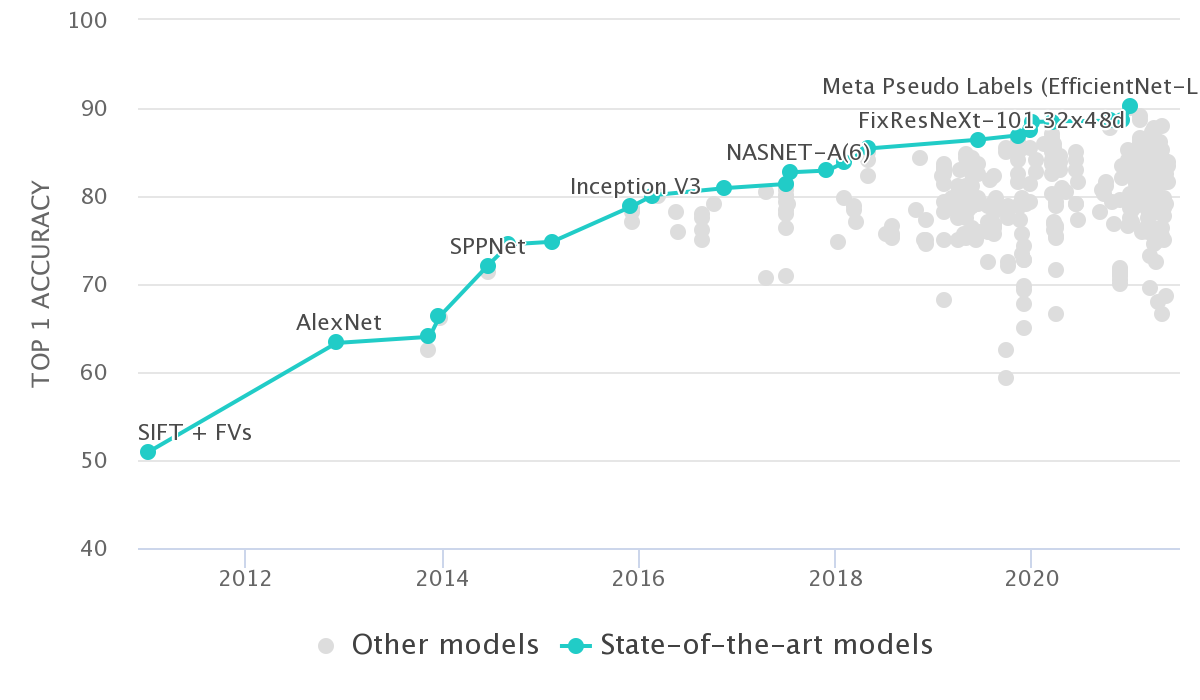


Models with top performance are:

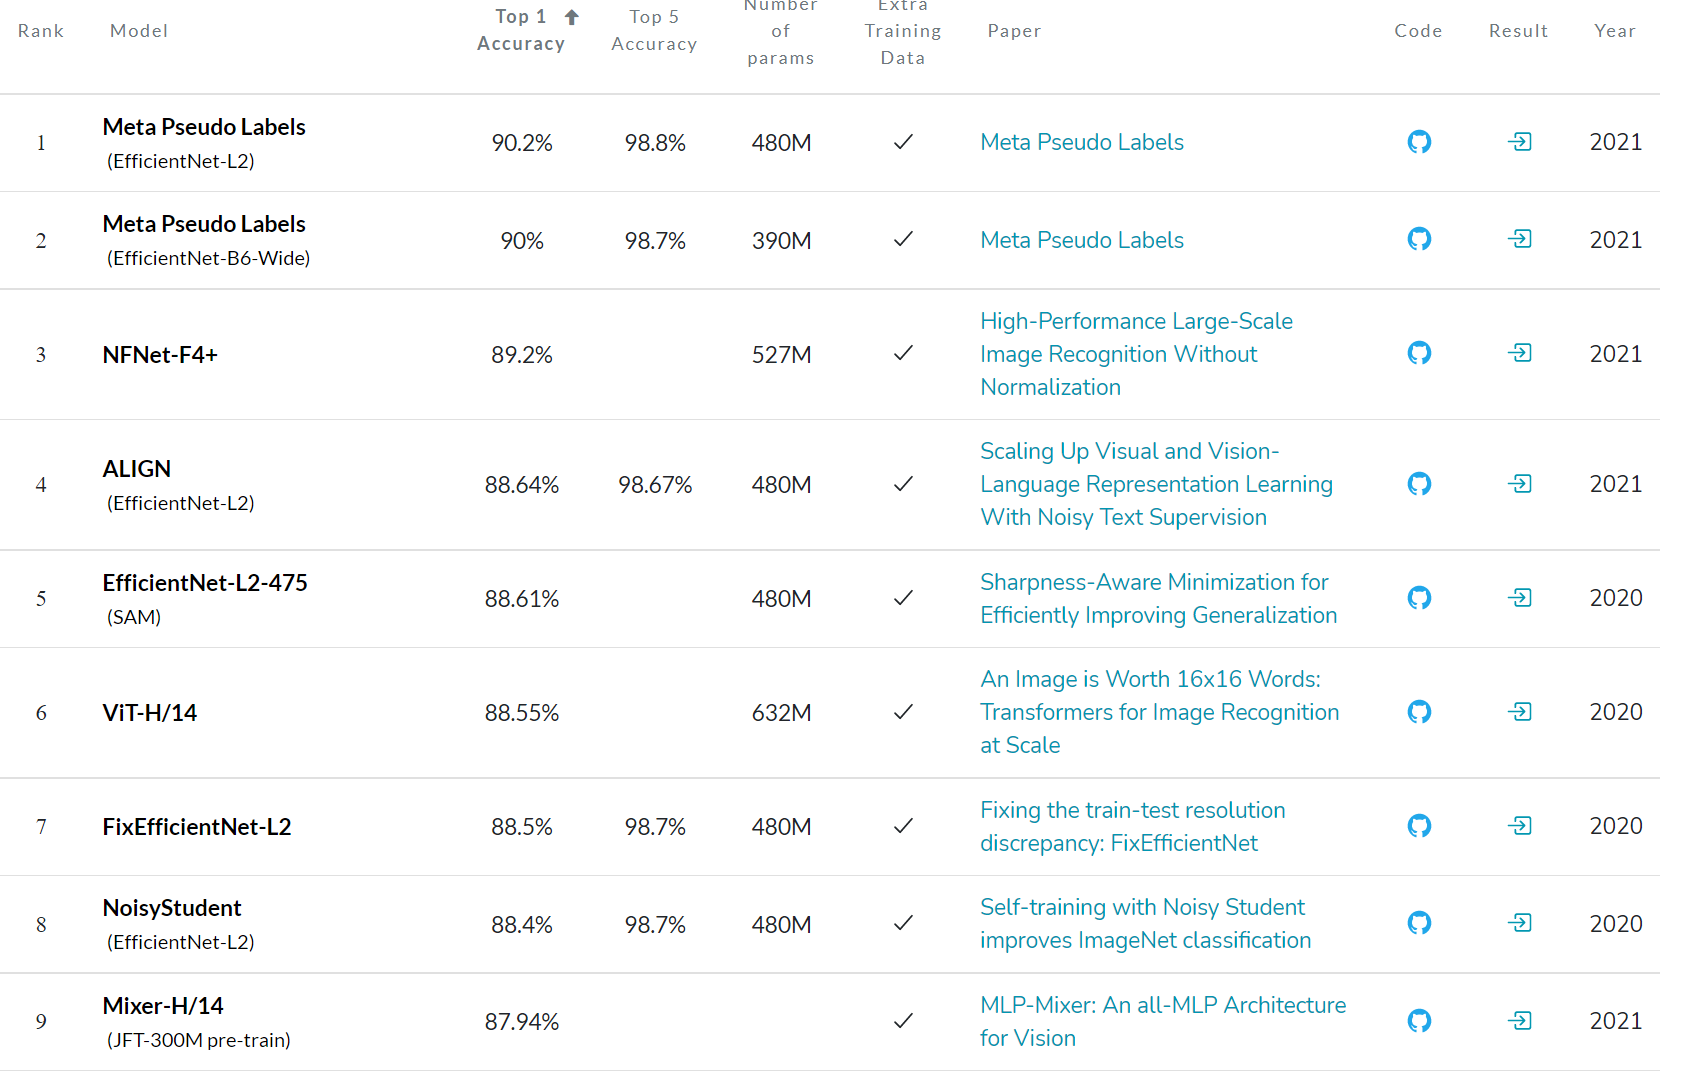

resnext101_32x8d looks like the best performance model in the list of available models, but still far from the lasted state-of-the-art models. Despite requires over 80 million parameters. I am trying to use this model for the transfer learning process. I decided to use resnet_150 because the number of parameters still low and is better for the resources available. This model requires image input with size 224x224 and has up to 2040 output classes. I also added to layers more for the transfer learning.

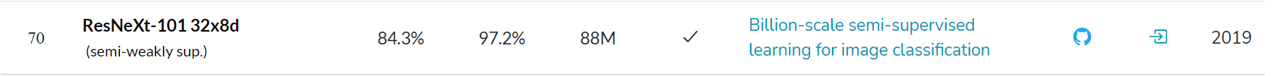

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [57]:
# criterion_transfer = None
# optimizer_transfer = None

# Define the learning rate parameter
LEARNING_RATE = 0.02

# Define the Loss function
criterion_transfer_learning = nn.CrossEntropyLoss()

# Define the optimizer
# Adma optimizer
optimizer_transfer_learning = optim.SGD(model_transfer_learning.fc.parameters(),lr=LEARNING_RATE)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [58]:
# Epochs parameter
EPOCHS_TRANSFER = 15

# train the model
model_transfer_learning = train(EPOCHS_TRANSFER, loader_tranfer_learning, model_transfer_learning, optimizer_transfer_learning, criterion_transfer_learning, use_cuda, 'model_transfer_learning.pt')


Epoch: 1 	Training Loss: 4.016331 	Validation Loss: 2.457735
validation loss decreased from inf to 2.457735. Model is being saved.
Epoch: 2 	Training Loss: 1.899642 	Validation Loss: 1.071904
validation loss decreased from 2.457735 to 1.071904. Model is being saved.
Epoch: 3 	Training Loss: 1.169738 	Validation Loss: 0.769503
validation loss decreased from 1.071904 to 0.769503. Model is being saved.
Epoch: 4 	Training Loss: 0.929112 	Validation Loss: 0.628906
validation loss decreased from 0.769503 to 0.628906. Model is being saved.
Epoch: 5 	Training Loss: 0.821051 	Validation Loss: 0.577886
validation loss decreased from 0.628906 to 0.577886. Model is being saved.
Epoch: 6 	Training Loss: 0.744737 	Validation Loss: 0.534009
validation loss decreased from 0.577886 to 0.534009. Model is being saved.
Epoch: 7 	Training Loss: 0.687405 	Validation Loss: 0.529109
validation loss decreased from 0.534009 to 0.529109. Model is being saved.
Epoch: 8 	Training Loss: 0.633370 	Validation Loss: 0

In [61]:
test(loader_tranfer_learning, model_transfer_learning, criterion_transfer_learning, use_cuda)

Test Loss: 0.471680


Test Accuracy: 86% (723/836)


I tried different models like Resnet-50 and Inception v2 but the accuracy was not the best and moved to Resbet152. I needed to add an additional layer for the transfer learning and with different Learning rates and optimizers. Finally, the best performance model achieved over 85% accuracy with 15 epochs.

In [26]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer_learning.load_state_dict(torch.load('model_transfer_learning.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [60]:
test(loader_tranfer_learning, model_transfer_learning, criterion_transfer_learning, use_cuda)

Test Loss: 0.500336


Test Accuracy: 83% (700/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [125]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loader_tranfer_learning['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    
    # Open the image related to he img_path
    img=Image.open(img_path).convert("RGB")
    
    # Define image transformation 
    img_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
                                       ])
    
        
    # Create the reshaped image tensor 
    image_tensor = img_transform(img).unsqueeze(0)
        
    # Validate the cuda availability
    if use_cuda:
        image_tensor = image_tensor.cuda()
        
    # Performing inference
    model_transfer_learning.eval()
    
    # Execute the inference and apply softmax function and extract the final value
    output = F.softmax(model_transfer_learning(image_tensor),dim=1).cpu().data.numpy().squeeze()    
    
    return class_names[np.argmax(output)]

Image file Input : {} /data/dog_images/test/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03258.jpg


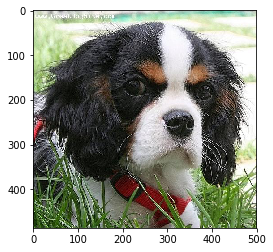

Predicted dog breed: {} Cavalier king charles spaniel


In [127]:
# Test the function
dog_files_test = np.array(glob("/data/dog_images/test/*/*"))
image_index = int(np.random.randint(0,len(dog_files_test),1))
breed_detected = predict_breed_transfer(dog_files_test[image_index])
print("Image file Input : {}",dog_files_test[image_index])
image = Image.open(dog_files_test[image_index])
plt.imshow(image)
plt.show()
print('Predicted dog breed: {}', breed_detected)

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [147]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
    
def run_app(img_path):
    
    '''
    Define a function to execute inference process to detect faces and fogd bred
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to RESNET-120 model's prediction
    '''    
    
    ## handle cases for a human face, dog, and neither
    
    # First look for human face 
    if face_detector(img_path):
        print("Face Detected")
        image = Image.open(img_path)
        plt.imshow(image)
        plt.show()
        print(f"Looks like: \n The {predict_breed_transfer(img_path)}\n")

    # If not face detectec check for dog breed
    elif dog_detector(img_path):
        print("Dog Detected")
        image = Image.open(img_path)
        plt.imshow(image)
        plt.show()
        print(f"Predicted breed:... \n{predict_breed_transfer(img_path)}\n")

    # Not face or dog detected
    else:
        print("Couldn't detect dogs or faces.\n")
        image = Image.open(img_path)
        plt.imshow(image)
        plt.show()

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

**Answer:**

The model trained using transfer learning with resnet152 pre-trained model achieved around 85% accuracy. I tried with some additional images, for example, two ShihZu images, and the model doesn't work well. and with dogs with mixed bred the model was confused. That means that there is a lot of improvement because 85% accuracy sounds ok but in practice still far from a good performance. Is clear that using a pre-trained model offers a fast and better way to train models for a specific task like dog breed detection. As I suggested when chose the pre-trained model, There more state-of-the-art models with more than 600 million parameters.

**Possible improvements**

 1. As was reviewed before, state-of-the-art models offer higher accuracy for the image classification tasks, can also provide better performance for the transfer learning task. These models require more resources for the training process.
 2. Aditional optimizations can be used to improve performance, like hyperparameter tuning and network pruning to accelerate inference time response.
 3. Increasing data with more sources using web scrapping and data augmentation using GAN networks to enrich the training process can provide better input for the training and validation process.
 4. New models based on a generative approach can be used to improve the transfer learning process.

Face Detected


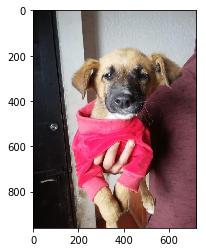

Looks like: 
 The Anatolian shepherd dog

Dog Detected


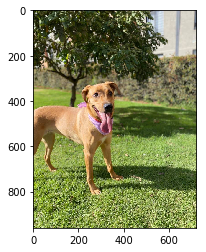

Predicted breed:... 
Canaan dog

Dog Detected


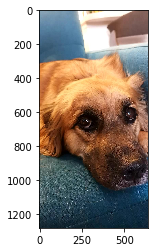

Predicted breed:... 
Cocker spaniel

Couldn't detect dogs or faces.



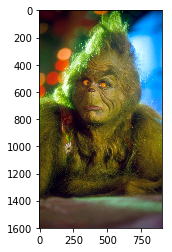

Dog Detected


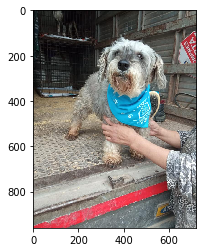

Predicted breed:... 
Lowchen

Face Detected


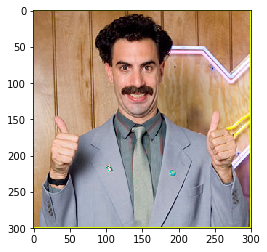

Looks like: 
 The Black russian terrier

Dog Detected


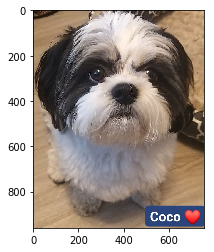

Predicted breed:... 
Lhasa apso

Dog Detected


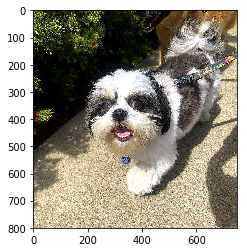

Predicted breed:... 
Black russian terrier



In [149]:
## suggested code, below
additional_files = np.array(glob("new_images/*"))
for file in additional_files:
    run_app(file)